# PSILOCYBIN MICE

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import topo as tp

In [3]:
_sal = sc.read_10x_mtx("/Users/npapadop/Documents/teaching/2024/GSE246451/saline/")
_sal.obs.index = _sal.obs.index + "-sal"
_sal.obs["condition"] = "saline"

In [4]:
_psi = sc.read_10x_mtx("/Users/npapadop/Documents/teaching/2024/GSE246451/psilo/")
_psi.obs.index = _psi.obs.index + "-psi"
_psi.obs["condition"] = "psilocybin"

In [5]:
import anndata as ad

In [6]:
adata = ad.concat((_sal, _psi))
del _sal, _psi

In [7]:
adata

AnnData object with n_obs × n_vars = 6958392 × 32285
    obs: 'condition'

filtering instructions: remove

- #features < 700
- %mito > 5
- doublets (DoubletFinder)

It turns out the matrix is too big for our paltry laptops. Let's believe the authors, and filter by #features first:

In [8]:
no_features_expressed = np.array(np.sum(adata.X > 0, axis=1))[:, 0]

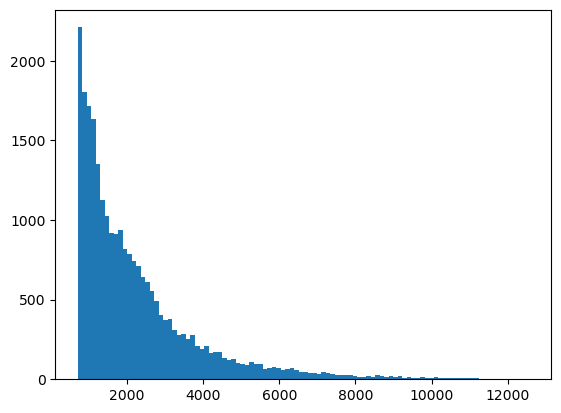

In [9]:
fig, ax = plt.subplots()
keep = no_features_expressed > 700
ax.hist(no_features_expressed[keep], bins=100);

actually subset:

In [10]:
adata = adata[keep].copy()

now let's annotate mitochondrial genes:

In [11]:
adata.var["mitochondrial"] = adata.var.index.str.contains("mt-")

calculate basic QC metrics:

In [12]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mitochondrial"], inplace=True)

Now actually filter for mitochondrial percentage:

In [13]:
adata.shape

(24995, 32285)

In [14]:
keep = adata.obs["pct_counts_mitochondrial"] <= 5
adata = adata[keep].copy()

In [15]:
adata.shape

(24987, 32285)

In [16]:
import scrublet as scr
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.0%
Elapsed time: 37.0 seconds


In [17]:
adata.obs["doublet score"] = doublet_scores
adata.obs["predicted doublet"] = predicted_doublets

In [18]:
adata.obs["predicted doublet"].sum()

3

Maybe not a very big issue after all vOv

First let's make a backup of the raw counts so that we can reset, if needed.

In [19]:
adata.layers["counts"] = adata.X.copy()

# normalisation!

In [20]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)

In [22]:
from anticor_features.anticor_features import get_anti_cor_genes

In [23]:
anti_cor_table = get_anti_cor_genes(adata.X.T,
                                    adata.var.index.tolist(),
                                    species="mmusculus")

selected_table = anti_cor_table[anti_cor_table["selected"]==True]
print(selected_table)

found 745.913143296 free Gb in /var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T
get_all_remove_genes
24987 1249
min_express_n 50
get_n_expressed
pathways_to_genes
    0              1    2                   3       4  \
0  g#  initial alias   c#     converted alias    name   
1   1     GO:0044429  1.1  ENSMUSG00000021607  MRPL36   
2   1     GO:0044429  1.2  ENSMUSG00000020869  LRRC59   
3   1     GO:0044429  1.3  ENSMUSG00000034932  MRPL54   
4   1     GO:0044429  1.4  ENSMUSG00000005360  SLC1A3   

                                                   5           6  
0                                        description  namespaces  
1  mitochondrial ribosomal protein L36 [Source:MG...        None  
2  leucine rich repeat containing 59 [Source:MGI ...        None  
3  mitochondrial ribosomal protein L54 [Source:MG...        None  
4  solute carrier family 1 (glial high affinity g...        None  
get_ensg_of_ref
    0              1                   2      3                4  \
0  g#  i

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


empirically determined Cneg cutoff: -0.018751156838649287  for FPR of: 0.001
empirically determined Cpos cutoff: 0.028026665180391323  for FPR of: 0.001
get_real_spear
[0, 5000, 10000, 15000, 16268]
working on 0 5000 vs 5000 10000
	getting spearman correlation
working on 0 5000 vs 10000 15000
	getting spearman correlation
working on 0 5000 vs 15000 16268
	getting spearman correlation
working on 5000 10000 vs 10000 15000
	getting spearman correlation
working on 5000 10000 vs 15000 16268
	getting spearman correlation
working on 10000 15000 vs 15000 16268
	getting spearman correlation


/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anticor_features/anticor_features.py:402: RuntimeWarning: divide by zero encountered in scalar divide
  FDR_vect[i] = FP_hat_vect[i]/all_sig_neg_vect[i]


                        gene  pre_remove_feature  pre_remove_pathway  \
Xkr4                    Xkr4               False               False   
Gm1992                Gm1992               False               False   
Gm19938              Gm19938               False               False   
Sox17                  Sox17               False               False   
Rgs20                  Rgs20               False               False   
...                      ...                 ...                 ...   
Uty                      Uty               False               False   
Gm21860              Gm21860               False               False   
Gm47283              Gm47283               False               False   
4933409K07Rik  4933409K07Rik               False               False   
AC149090.1        AC149090.1               False               False   

               pre_remove_low_express  n_expressed  percent_expressed  \
Xkr4                            False      18023.0           0

In [24]:
adata.var = pd.concat([adata.var, anti_cor_table], axis=1)

## Dimensionality estimation

In [25]:
from topo.tpgraph.intrinsic_dim import IntrinsicDim

In [26]:
hvg = adata[:, adata.var["selected"] == True].copy()

In [27]:
id_est = IntrinsicDim(
    methods=['fsa', 'mle'], # the methods we'll use
    k=range(10, 200, 10), # the number of k-neighbors to test
    backend='hnswlib',  # the approximate kNN backend to use
    metric='cosine', # the distance metric to use
    n_jobs=-1, # the number of jobs to run in parallel
    plot=True, # whether to plot the results during fit()
    random_state=None) # the random state to use for colors

# Estimate the i.d.
id_est.fit(hvg.X)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/topo/base/ann.py:124: UserWarning: hnswlib does not support sparse matrices. Converting to array...
  warn("hnswlib does not support sparse matrices. Converting to array...")
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/topo/tpgraph/intrinsic_dim.py:209: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [30]:
%matplotlib inline

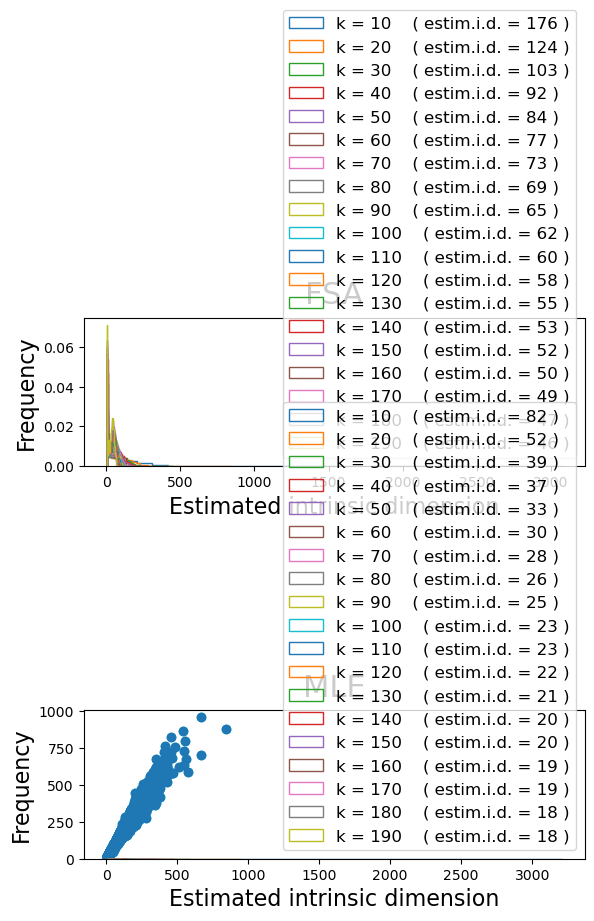

Spearman R correlation: 0.996


In [31]:
from scipy.stats import spearmanr

# Compare the results for 20 k-nearest-neighbors
fsa_local = id_est.local_id['fsa']['20']
mle_local = id_est.local_id['mle']['20']

corr, _ = spearmanr(fsa_local, mle_local)

plt.scatter(fsa_local, mle_local)
plt.show()

print('Spearman R correlation: %.3f' % corr)

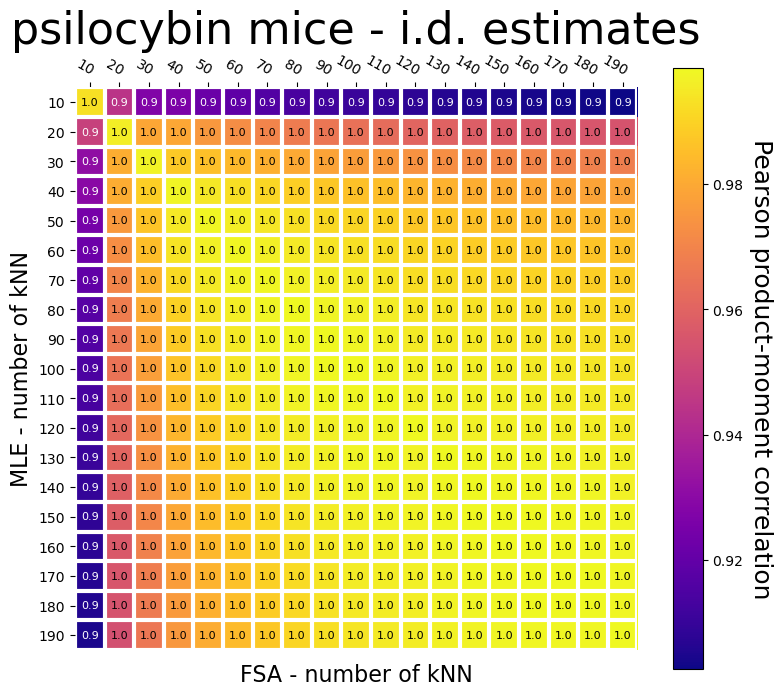

In [42]:
# Compute correlation between the i.d. estimates for each kNN value
keys = []
corr = []
for i_id, k_fsa in enumerate(id_est.local_id['fsa']):
    keys.append(k_fsa)
    for i_id, k_mle in enumerate(id_est.local_id['mle']):
        corr.append(spearmanr(id_est.local_id['fsa'][k_fsa], id_est.local_id['mle'][k_mle])[0])

# Create square array of correlations from the list
cor_array = np.array(corr).reshape((19, 19))
cor_array

# Plot as a heatmap
fig, ax = plt.subplots(figsize=(8,8))

im, cbar = tp.pl.heatmap(cor_array, keys, keys, ax=ax,
                   cmap="plasma", cbarlabel="Pearson product-moment correlation", cbar_fontsize=18, shrink=0.8, cb_pad=0.05)

# Annotated heatmap
texts = tp.pl.annotate_heatmap(im, valfmt="{x:.1f}", textcolors=("white", "black"), an_fontsize=8)

ax.set_xlabel('FSA - number of kNN', fontsize=16)
ax.set_ylabel('MLE - number of kNN', fontsize=16)
ax.set_title('psilocybin mice - i.d. estimates', fontsize=32)
fig.tight_layout()
plt.show()

In [43]:
# Create TopOGraph object using 20 kNN
tg = tp.TopOGraph(base_knn=30, 
                    n_eigs=110, # set this to the largest estimate!
                    n_jobs=-1,
                    verbosity=0)

# Run a TopOMetry model
hvg = tp.sc.topological_workflow(
    hvg,                  # the anndata object
    tg,                # the TopOGraph object
    kernels=['bw_adaptive'],# the kernel(s) to use
    eigenmap_methods=['DM'],# the eigenmap method(s) to use
    projections=['MAP'],    # the projection(s) to use
    resolution=2.0          # the Leiden clustering resolution
)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/topo/base/ann.py:124: UserWarning: hnswlib does not support sparse matrices. Converting to array...
  warn("hnswlib does not support sparse matrices. Converting to array...")


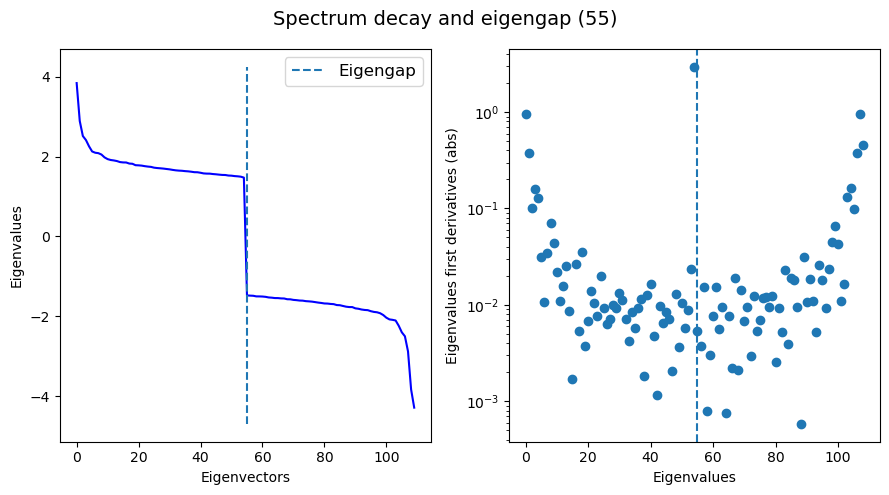

In [44]:
tg.eigenspectrum()

In [ ]:
adata.uns["proposed_dimensionality"] = 80

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP

sc.pp.scale(hvg, max_value=10)

pca_op = PCA(n_components=adata.uns["proposed_dimensionality"]) # compute similar amount of components for fair comparison
pca_Y = pca_op.fit_transform(hvg.X)

umap_PCA = UMAP(n_components=2, metric='cosine').fit_transform(pca_Y)

In [ ]:
evaluation_dict = tp.pipes.eval_models_layouts(tg, hvg.X,
                                                    kernels=['bw_adaptive'],
                                                    eigenmap_methods=['msDM','DM','LE'],
                                                    projections=['MAP'],
                                                    additional_eigenbases={"PCA_scale": pca_Y},
                                                    additional_projections={'UMAP': umap_PCA},
                                                    n_neighbors=3,
                                                    n_pcs=adata.uns["proposed_dimensionality"],
                                                    n_jobs=-1, 
                                                )

In [ ]:
pd.DataFrame(evaluation_dict)

In [ ]:
# save best embeddings
adata.obsm["X_PCA"] = pca_Y
adata.obsm["X_DM"] = tg.EigenbasisDict['DM with bw_adaptive'].results()

# save two best projections
adata.obsm["X_topo"] = tg.ProjectionDict['MAP of bw_adaptive from DM with bw_adaptive']
adata.obsm["X_umap"] = umap_PCA

# keep track of our choices
adata.uns["X_topo"] = 'MAP of bw_adaptive from LE with bw_adaptive'
adata.uns["topo_eval_dict"] = evaluation_dict

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.embedding(adata, basis="X_umap", ax=ax)